In [1]:
!pip install requests==2.32.4 langchain langchain_core langchain_community langgraph langchain-groq PyMuPDF

INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is still looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. Thi

In [2]:
from google.colab import files
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print(f"uploaded: {fname}")


Saving Akhila_Devarapalli_CV_Latest_India.pdf to Akhila_Devarapalli_CV_Latest_India.pdf
uploaded: Akhila_Devarapalli_CV_Latest_India.pdf


In [3]:
import fitz

cv_text = ""
pdf = fitz.open(fname)
for page in pdf:
    cv_text += page.get_text() + "\n\n"
pdf.close()

print(cv_text)

Akhila Devarapalli
linkedin.com/in/akhiladevarapalli | github.com/akhidevGIT | devarapalliakhila@gmail.com
Skills
Programming Languages: Python, SQL, R, JavaScript, HTML, CSS
Technologies: Git, Docker, AWS, Shiny, FastAPI, Flask, Power BI, Microsoft Excel (VBA), Jira
Projects
• Multi-Label Text Classification: Bi-directional LSTM model with Word Embeddings to classify online comments into toxicity
levels (88% precision). GitHub
Tools & Technologies: Python, TensorFlow, Keras, tf.keras (Sequential API), NLP, Pandas, NumPy, Matplotlib, Seaborn
• Sentiment Analysis: Rule-based (TextBlob) & transformer-based (BERT) sentiment scoring for product reviews. GitHub
Tools & Technologies: Python, TextBlob, Hugging Face Transformers, Pandas, NumPy, Matplotlib, Seaborn
• Churn Prediction: Segmented customers & predicted churn risk using Bagging/Boosting (84% accuracy). GitHub
Tools & Technologies: Scikit-learn, Imbalanced-learn (SMOTE), Pandas, Matplotlib, Seaborn
• Image Classification: Built a CN

In [4]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model = "llama-3.3-70b-versatile", temperature=0.7)

In [6]:
from typing_extensions import TypedDict

class resume(TypedDict):
    resume_content: str
    experience_yrs: float
    education: list
    skills: list
    projects: list
    experience_roles: list
    desired_role: str
    experience_level: str
    match_score: float
    recommended_projects: list
    skills_to_improve: list
    top_roles: list
    final_feedback: str




In [7]:
from langchain_core.output_parsers import JsonOutputParser
parser = JsonOutputParser()

In [8]:
from langchain_core.prompts import ChatPromptTemplate

def resume_parser_agent(state: resume) -> resume:
  resume_text = state.get("resume_content", "")

  prompt = ChatPromptTemplate.from_template(
      f""" Extract the following fields from the resume text.
      Return only valid JSON with keys: : years_experience (float: calculate years of experience including months e.g. 2.5), experience_roles (list of job roles as short strings), skills (list of short lower-case tokens), projects (list of short strings), education (list of short strings).
      If a field is unknown or cannot be determined, set it to null or an empty list.
      Resume text:  {resume_text}
      """
  )
  chain = prompt|llm
  result = chain.invoke({"resume_text": resume_text}).content

  parsed_content = parser.parse(result)

  experience_yrs = parsed_content["years_experience"]
  experience_roles = parsed_content["experience_roles"]
  education = parsed_content["education"]
  skills = parsed_content["skills"]
  projects = parsed_content["projects"]

  return {"experience_yrs": experience_yrs, "experience_roles":experience_roles, "education": education, "skills": skills, "projects": projects}



In [9]:
def skill_analyser_agent(state:resume) -> resume:
  resume_text = state.get("resume_content", "")
  desired_role = state.get("desired_role", "")

  prompt = ChatPromptTemplate.from_template(
      f"""
        You are an expert career coach AI.

        Analyze the following resume and evaluate the candidate's experience level and suitability for a target job role.

        ### Resume:
        {resume_text}

        ### Target Role:
        {desired_role}

        Your tasks:
        1. **Categorize** the candidate as one of:
          - "Entry-level" → 0–2 years experience or mostly academic/internship experience
          - "Mid-level" → 2–6 years experience or mix of independent and collaborative work
          - "Senior-level" → 6+ years experience or leadership/project ownership

        2. **Estimate a Match Score (0–100)** that reflects how well this resume aligns with the target role, based on skills, experience, and context.

        3. Keep the output concise and structured in **JSON** format with two keys:

            "experience_level": "<Entry-level | Mid-level | Senior-level>",
            "match_score": <number between 0 and 100>

          """
        )
  chain = prompt | llm
  result = chain.invoke({"resume_text": resume_text, "desired_role": desired_role}).content
  skill_analysis = parser.parse(result)

  return {"experience_level": skill_analysis["experience_level"], "match_score": skill_analysis["match_score"]}

In [10]:
def role_match_agent(state:resume) -> resume:
  resume_text = state.get("resume_content", "")

  prompt = ChatPromptTemplate.from_template(
      f"""
      You are a career coach AI. Analyze this resume and suggest top 3 job roles
      that fit the candidate based on their skills and experience.

      Resume summary:
      {resume_text}

      Return only valid JSON with key:  top_roles (list of 3 job titles as short strings)

      """
  )
  chain = prompt|llm
  role_match_content = chain.invoke({"resume_text": resume_text}).content
  parsed_content = parser.parse(role_match_content)


  return {"top_roles": parsed_content['top_roles']}



In [11]:
def alignment_explainer_agent(state: resume) -> resume:
    resume_text = state.get("resume_content", "")
    desired_role = state.get("desired_role", "")
    top_roles = state.get("top_roles", [])

    prompt = ChatPromptTemplate.from_template(
        f"""
        You are a recruiter AI. The candidate applied for the role "{desired_role}",
        but your analysis shows their top suggested roles are: {top_roles}.

        Explain clearly *why* their resume: {resume_text}  may not align well with the desired role,
        and what they can change (skills, keywords, or experience emphasis)
        to improve their alignment.

        Return only plain text feedback (no JSON).
        """
    )

    chain = prompt | llm
    feedback = chain.invoke({"resume_text": resume_text, "desired_role": desired_role, "top_roles": top_roles}).content
    return {"final_feedback": feedback}


In [12]:
def skill_project_recommender_agent(state:resume) -> resume:
  resume_text = state.get("resume_content", "")
  desired_role = state.get("desired_role", "")

  prompt = ChatPromptTemplate.from_template(
      f"""
      You are an expert career mentor AI helping candidates improve their resumes for specific roles.

      Analyze the following information and give actionable suggestions.

      ### Resume:
      {resume_text}

      ### Target Role:
      {desired_role}

      Your tasks:
      1. Review the candidate’s resume to understand their current skills, experience, and domain knowledge.
      2. Compare their profile with the typical expectations for the target role.
      3. Suggest:
        - **3 Projects** the candidate can build or contribute to that would make their portfolio stand out for this role.
        - **3 Skills** they should improve or learn to strengthen their fit.

      Format the output in **JSON** format with two keys in this exact structure:

      "recommended_projects": [<project 1>, <project 2>, <project 3>],
      "skills_to_improve": [<skill 1>, <skill 2>, <skill 3>]

      """
  )

  chain = prompt | llm
  result = chain.invoke({"resume_text": resume_text, "desired_role": desired_role}).content
  skill_projects_recom = parser.parse(result)

  return {"recommended_projects": skill_projects_recom["recommended_projects"], "skills_to_improve": skill_projects_recom["skills_to_improve"]}



In [13]:
def feedback_agent(state: resume) -> resume:

    resume_text = state.get("resume_content","")
    desired_role = state.get("desired_role","")
    experience_level = state.get("experience_level", "")
    top_roles = state.get("top_roles", [])
    match_score = state.get("match_score", 0)
    projects = state.get("recommended_projects", [])
    skills_plan = state.get("skills_to_improve", [])
    explanation = state.get("final_feedback", "")  # might contain alignment feedback if previous step

    # === Dynamic prompt construction ===
    prompt_text = f"""
    You are an expert career coach. Summarize the candidate’s resume evaluation
    and generate a clear, short feedback report in bullet points.

    ### Resume Summary:
    {resume_text}

    ### Target Role:
    {desired_role}

    ### Profile Summary:
    - Experience Level: {experience_level}
    - Resume Match Score: {match_score if match_score else "N/A"}
    - Suggested Roles: {top_roles if top_roles else "Not determined"}

    """

    # Add dynamic context depending on flow
    if match_score and match_score >= 80:
        prompt_text += """
        The candidate is already a strong fit for this role.
        Highlight their strengths and reassure them that their profile aligns well.
        Suggest any final polish tips or portfolio improvements.
        """

    elif "Senior-level" in experience_level.lower() and match_score and match_score >= 50:
        prompt_text += """
        The candidate is senior-level.
        Focus feedback on leadership visibility, mentoring, and impact demonstration.
        """

    elif explanation:
        prompt_text += f"""
        There was some role alignment feedback generated:
        {explanation}
        Please integrate this insight into the summary.
        """

    else:
        prompt_text += f"""
        Provide improvement recommendations and skill-building actions.
        If available, include these project and skill suggestions:
        - Projects: {projects}
        - Skills to improve: {skills_plan}
        """

    prompt_text += """
    Format the output as:
    **Strengths**
    - ...
    **Areas to Improve**
    - ...
    **Actionable Suggestions**
    - ...
    Keep it under 200 words.
    """

    # === LLM Call ===
    prompt = ChatPromptTemplate.from_template(prompt_text)
    chain = prompt | llm
    feedback_text = chain.invoke({"resume_text": resume_text, "desired_role": desired_role}).content

    return {"final_feedback": feedback_text}


In [14]:
def route_after_skill_analysis(state: resume):
    score = state.get("match_score", 0)
    level = state.get("experience_level", "")
    if score >= 80 or "Senior-level" in level:
        return "high_match"
    # Others proceed to role-based analysis
    return "needs_role_analysis"

def route_after_role_match(state: resume):
    desired = state.get("desired_role", "").lower()
    top_roles = [r.lower() for r in state.get("top_roles", [])]
    if desired not in top_roles:
        return "alignment_needed"
    return "skills_needed"



In [15]:
from langgraph.graph import StateGraph, START, END
builder = StateGraph(resume)
# Add nodes
builder.add_node("resume_parser", resume_parser_agent)
builder.add_node("skill_analyzer", skill_analyser_agent)
builder.add_node("role_matcher", role_match_agent)
builder.add_node("alignment_explainer", alignment_explainer_agent)
builder.add_node("skill_project_suggester", skill_project_recommender_agent)
builder.add_node("final_feedback", feedback_agent)

In [16]:
# Add base edges
builder.add_edge(START, "resume_parser")
builder.add_edge("resume_parser", "skill_analyzer")

# Conditional edges based on analyzer output
builder.add_conditional_edges("skill_analyzer", route_after_skill_analysis,{
        "high_match": "final_feedback",
        "needs_role_analysis": "role_matcher"
    })

builder.add_conditional_edges("role_matcher", route_after_role_match, {
        "alignment_needed": "alignment_explainer",
        "skills_needed": "skill_project_suggester"
    })

# Continue from middle nodes to final
builder.add_edge("alignment_explainer", "final_feedback")
builder.add_edge("skill_project_suggester", "final_feedback")

builder.add_edge("final_feedback", END)

workflow = builder.compile()

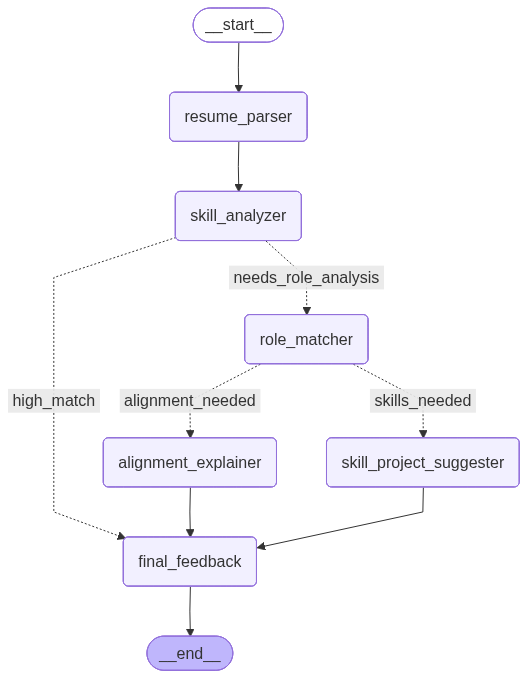

In [17]:
from IPython.display import Image, display

display(
    Image(
        workflow.get_graph().draw_mermaid_png()
    )
)

In [24]:
def run_resume_screening(cv: str, role: str):
  results = workflow.invoke({"resume_content" : cv, "desired_role": role})
  return {

    "experience_yrs": results.get('experience_yrs', 0),
    "education": results.get('education', []),
    "skills": results.get('skills', []),
    "projects": results.get('projects', []),
    "desired_role": results.get('desired_role',""),
    "experience_level": results.get('experience_level', ""),
    "match_score": results.get('match_score', 0),
    "recommended_projects": results.get('recommended_projects', []),
    "skills_to_improve": results.get('skills_to_improve', []),
    "top_roles": results.get('top_roles', []),
    "final_feedback": results.get('final_feedback', "")
  }


In [25]:
desired_role = "Data Scientist"
results = run_resume_screening(cv_text, desired_role)
print("\n\nComputed Results :")
print(results)



Computed Results :
{'experience_yrs': 7.5, 'education': ['master of science in business analytics, lancaster university', 'master of technology in metallurgical and materials science engineering, iit madras', 'bachelor of technology in metallurgical and materials science engineering, iit madras'], 'skills': ['python', 'sql', 'r', 'javascript', 'html', 'css', 'git', 'docker', 'aws', 'shiny', 'fastapi', 'flask', 'power bi', 'microsoft excel', 'vba', 'jira', 'tensorflow', 'keras', 'nlp', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'imbalanced-learn', 'opencv', 'computer vision', 'hugging face transformers', 'textblob'], 'projects': ['multi-label text classification', 'sentiment analysis', 'churn prediction', 'image classification'], 'desired_role': 'Data Scientist', 'experience_level': 'Mid-level', 'match_score': 92, 'recommended_projects': [], 'skills_to_improve': [], 'top_roles': [], 'final_feedback': "**Strengths**\n- Strong technical skills in programming languages a

In [26]:
print(f"feedback: \n{results.get('final_feedback')}")

feedback: 
**Strengths**
- Strong technical skills in programming languages and technologies relevant to the Data Scientist role
- Impressive project portfolio with hands-on experience in machine learning, natural language processing, and data visualization
- Mid-level experience in data science with a proven track record of improving models and processes

**Areas to Improve**
- None significant, as the candidate's profile aligns well with the target role

**Actionable Suggestions**
- Consider adding a brief summary or objective statement at the top of the resume to highlight career goals and job aspirations
- Continue to update and expand the project portfolio to demonstrate ongoing learning and growth in the field
- Ensure all online profiles (e.g., LinkedIn, GitHub) are up-to-date and consistent with the resume to maximize visibility to potential employers.
